https://www.strava.com/activities/3169231179/overview

In [69]:
import json

import pandas as pd
import geopandaas as gpd
import fiona
import altair as alt
from vega_datasets import data
import folium
from folium.plugins import TimestampedGeoJson

In [2]:
fname = "../data/_Onefootball_3_1_Exozet.gpx"

# Parse GPX data

In [3]:
fiona.listlayers(fname)

['waypoints', 'routes', 'tracks', 'route_points', 'track_points']

In [323]:
# https://geopandas.org/io.html#reading-spatial-data
gdf = (
    gpd.read_file(
        fname, layer="track_points"
    )[['track_seg_point_id', 'ele', 'time', 'geometry']]
    .rename(columns=dict(track_seg_point_id="id"))
    .set_index("id")
)
gdf["time"] = pd.to_datetime(gdf.time, format='%Y-%m-%dT%H:%M:%S').values.astype('int64') // 10 ** 6
gdf.dtypes

ele          float64
time           int64
geometry    geometry
dtype: object

In [324]:
meter_gdf = gdf.to_crs(epsg=3310)
gdf["distance"] = meter_gdf.distance(meter_gdf.shift())

In [325]:
gdf["style"] = len(gdf) * [dict(color="blue")]  # , marcker_icon="dot-circle"
gdf["icon"] = "circle"  # "fa-dot-circle"  # "Marker"  # "circle"  #  "dot-circle"

In [369]:
gdf["speed"] = gdf["distance"] / (gdf.time.diff() / 1_000)

In [370]:
gdf["two_minutes_break"] = (gdf['time'].diff() / 1_000) > 120

In [199]:
gdf_linestring = gpd.read_file(fname, layer="tracks")[['name', 'geometry']]

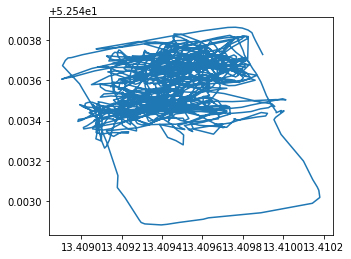

In [201]:
gdf_linestring.plot()

In [316]:
gdf.head()

,ele,geometry,times,distance,style,icon
id,,,,,,
0,83.2,POINT (13.40990 52.54372),[1583776677000],NaN,{'color': 'blue'},circle
1,83.2,POINT (13.40990 52.54372),[1583776678000],0.000000,{'color': 'blue'},circle
2,83.2,POINT (13.40986 52.54380),[1583776684000],8.453890,{'color': 'blue'},circle
3,83.2,POINT (13.40985 52.54382),[1583776685000],2.122080,{'color': 'blue'},circle
4,83.2,POINT (13.40985 52.54384),[1583776686000],1.877629,{'color': 'blue'},circle


# Altair Geoshape plot

Altair recipe:
- alt.Chart() => dataframe
- .mark_xx() => the kind of chart point
- .encode() => how to encode the data in the df for the chart
- .properties().interactive() => other properties, independent of data

In [321]:
position_plot = (
    alt
    .Chart(gdf)
    .mark_geoshape(
        stroke='white'
    )
    .encode(
        color=alt.Color('distance'),
    )
    .properties(
        width=600,
        height=500
    )
)
position_plot

alt.Chart(...)

**Note**: Altair doesn't support adding a basemap to a plot (because Vega-lite doesn't support it)

In [358]:
speed_plot = (
    alt.Chart(gdf)
    .mark_line(
    )
    .encode(
        x=alt.X('time:T', axis=alt.Axis(format='%H:%M')),
        y='speed',
    )
    .properties(
        width=700,
        height=100
    )
)
speed_plot

alt.Chart(...)

In [372]:
alt.Chart(gdf).mark_tick().encode(
        x=alt.X('time:T', axis=alt.Axis(format='%H:%M')),
        y='two_minutes_break',
)

alt.Chart(...)

# Time Series geo JSON

In [318]:
max_zoom = 18

In [326]:
# https://python-visualization.github.io/folium/plugins.html#folium.plugins.TimestampedGeoJson
m = folium.Map(
    location=[gdf_linestring.centroid.y, gdf_linestring.centroid.x], 
    zoom_start=max_zoom,
    tiles='OpenStreetMap',
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False
)
TimestampedGeoJson(
    data=gdf.to_json(),
    transition_time=100,
    period='PT5S',
    duration='PT20S',
    loop=False,
    auto_play=False,
    loop_button=True
).add_to(m)
m.save('../data/timestamped_geojson_onefootball_game.html')
m

TODO:
- do a central symmetry for second half (or not)
- place the  goalposts
- measure distance to goals